In [56]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import os

In [57]:
# Hyper param
epoch_num = 100
batch_size = 128
lr = 1e-4
class_num = 7

# Dataset preprocessing

In [58]:
# Read data (48x48 pixel gray scale images)
# Dataset link: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
train_dir = '../../data/emotion-detection/train'
test_dir = '../../data/emotion-detection/test'

transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])

train_dataset = datasets.ImageFolyder(train_dir,transform=transform)
test_dataset = datasets.ImageFolder(test_dir,transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


## Test the dataloader

torch.Size([1, 48, 48])


Text(0.5, 1.0, 'angry')

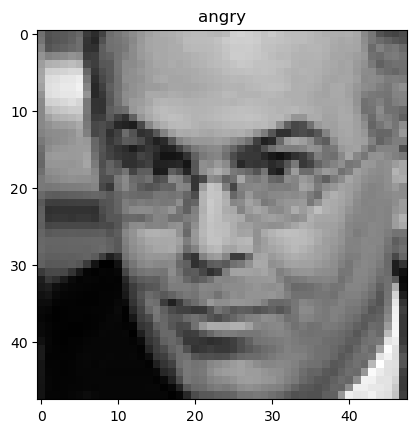

In [59]:
testdata = next(iter(train_loader))
pic = testdata[0][0]
print(pic.size())
label = testdata[1][0]

idx_to_class = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
plt.imshow(np.reshape(pic, pic.size()[1:]), cmap='gray')
plt.title(idx_to_class[label])

# Define model

In [60]:
# Model
class CNN(nn.Module):
    def __init__(self,):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, True),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2, True),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2, True),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
        )

        self.average_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512, class_num)
        self.output = nn.Softmax()

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.average_pool(out)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        return self.output(out)

In [61]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
torch.cuda.is_available()

True

# Countinue training from checkpoint

In [62]:
train_loss_list = []
val_loss_list = []
resume_epoch = 0

In [ ]:
try:
    most_recent_check_point = os.listdir('checkpoint')[-1]
    ckpt_path = os.path.join('checkpoint', most_recent_check_point)
    check_point = torch.load(ckpt_path)
    # load model
    model.load_state_dict(check_point['state_dict'])
    resume_epoch = check_point['epoch']
    train_loss_list = check_point['train_loss_list']
    val_loss_list = check_point['val_loss_list']
    print(f'Successfully load checkpoint {most_recent_check_point}, '
          f'start training from epoch {resume_epoch + 1}')
    plt.plot(train_loss_list, label='train')
    plt.plot(val_loss_list, label='validation')
    plt.title("Loss")
    plt.legend()
    plt.show()
except:
    print('fail to load checkpoint, train from zero beginning')

for _ in range(resume_epoch):
    scheduler.step()

# Training

In [64]:
for epoch in range(resume_epoch + 1, epoch_num):
    for i, (pics, labels) in enumerate(train_loader):
        pics = pics.to(device)
        labels = labels.to(device)
        output = model(pics)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_list.append(loss.item())
    with torch.no_grad():
        val_pics, val_labels = next(iter(test_loader))
        val_pics = val_pics.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_pics)
        val_loss = criterion(val_output, val_labels)
        val_loss_list.append(val_loss.item())


    print(
        f'Epoch: {epoch} / {epoch_num}\t'
        f'train_loss: {train_loss_list[-1]:.8f}\t'
        f'val_loss: {val_loss_list[-1]:.8f}\t'
        f'lr: {optimizer.state_dict()["param_groups"][0]["lr"]:.8f}\t'
    )

    scheduler.step()

    # save ckpt
    if epoch % 10 == 0:
        os.makedirs('checkpoint', exist_ok=True)
        torch.save({'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'train_loss_list': train_loss_list,
                    'val_loss_list': val_loss_list,
                    }, f'checkpoint/{epoch:03d}.pt')

C:\Users\xiang\AppData\Local\Temp\ipykernel_10108\1659514687.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.output(out)


Epoch: 1 / 100	train_loss: 1.89661348	val_loss: 1.81841910	lr: 0.00010000	
Epoch: 2 / 100	train_loss: 1.81906557	val_loss: 1.79734111	lr: 0.00009800	
Epoch: 3 / 100	train_loss: 1.84510267	val_loss: 1.82028580	lr: 0.00009604	
Epoch: 4 / 100	train_loss: 1.78454471	val_loss: 1.83039880	lr: 0.00009412	
Epoch: 5 / 100	train_loss: 1.75914907	val_loss: 1.73708701	lr: 0.00009224	
Epoch: 6 / 100	train_loss: 1.75899506	val_loss: 1.81575787	lr: 0.00009039	
Epoch: 7 / 100	train_loss: 1.80063605	val_loss: 1.80666173	lr: 0.00008858	
Epoch: 8 / 100	train_loss: 1.72404289	val_loss: 1.78151071	lr: 0.00008681	
Epoch: 9 / 100	train_loss: 1.75920045	val_loss: 1.77988362	lr: 0.00008508	
Epoch: 10 / 100	train_loss: 1.69585359	val_loss: 1.69339132	lr: 0.00008337	
Epoch: 11 / 100	train_loss: 1.77854633	val_loss: 1.73227632	lr: 0.00008171	
Epoch: 12 / 100	train_loss: 1.79049289	val_loss: 1.69278288	lr: 0.00008007	
Epoch: 13 / 100	train_loss: 1.76908648	val_loss: 1.66309369	lr: 0.00007847	
Epoch: 14 / 100	train

# Draw loss curve

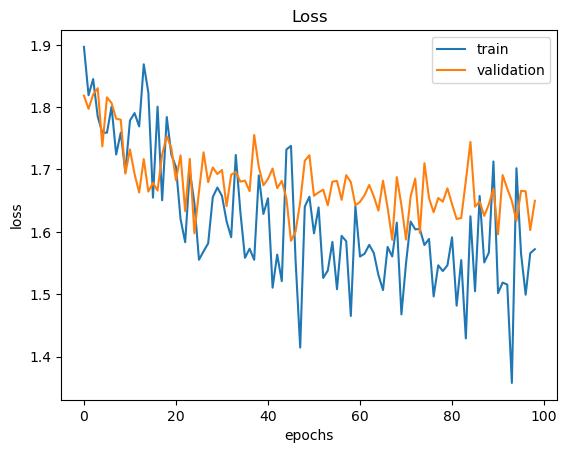

In [65]:
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()

# Test the model

In [66]:
with torch.no_grad():
    correct = 0
    total = 0
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        output = model(imgs)

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy: {correct / total}')

C:\Users\xiang\AppData\Local\Temp\ipykernel_10108\1659514687.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.output(out)


Accuracy: 0.5101699637782112


# Save model

In [67]:
torch.save(model, 'model.pth')
torch.save(model.state_dict(), 'params.ckpt')

In [68]:
model.state_dict()

OrderedDict([('layer1.0.weight',
              tensor([[[[ 0.2516, -0.0986,  0.2848],
                        [-0.2878, -0.0238, -0.1890],
                        [-0.2639,  0.1026,  0.0204]]],
              
              
                      [[[ 0.1666, -0.1472,  0.1949],
                        [-0.1171,  0.1753,  0.1157],
                        [-0.0049, -0.0330,  0.2442]]],
              
              
                      [[[ 0.1057,  0.0811,  0.1824],
                        [ 0.3446,  0.0518,  0.1822],
                        [ 0.1922,  0.0662,  0.1820]]],
              
              
                      [[[-0.2245,  0.1154,  0.2187],
                        [ 0.1154,  0.0446, -0.1452],
                        [ 0.1828, -0.1300, -0.1595]]],
              
              
                      [[[ 0.2373,  0.2242,  0.1698],
                        [-0.2576, -0.0627,  0.1865],
                        [-0.2639,  0.0500,  0.0687]]],
              
              
            